# **Model Interpretability**

In [1]:
%pip install -q -r ../requirements.txt

Note: you may need to restart the kernel to use updated packages.


In [2]:
import os
import pickle
import glob

import pandas as pd
import numpy as np

import shap
import matplotlib.pyplot as plt
import seaborn as sns

from collections import Counter
from sklearn.base import clone
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import LabelEncoder

RES_DIR = os.path.join('..', 'resources')
IMG_DIR = os.path.join("..", "results", "shap", "imgs")
CSV_DIR = os.path.join("..", "results", "shap", "csv")
os.makedirs(RES_DIR, exist_ok=True)
os.makedirs(IMG_DIR, exist_ok=True)
os.makedirs(CSV_DIR, exist_ok=True)

DATA_FILE = "reduced_data_rf2_tidy.csv"

MODEL_NAME = 'XGB_ROS_RS_NoDR_Opt'
MODEL_PATH = os.path.join('..', 'models', f"{MODEL_NAME}.pkl")

shap.initjs()

In [3]:
def load_or_compute_shap(predictor, processed_data, feature_names, class_names, dirpath='.', prefix='shap_values_class_', overwrite=False):
    """
    Load SHAP values from CSV files if they exist, otherwise compute and save them.

    Parameters:
    - predictor: Function to predict probabilities (e.g., classifier.predict_proba).
    - processed_data: Processed data used for SHAP computation.
    - feature_names: List of feature names.
    - dirpath: Directory path to save/load CSV files.
    - prefix: Prefix for the CSV files.
    - overwrite: Boolean to overwrite existing files.
    """

    # Find all CSV files that start with the prefix
    pattern = os.path.join(dirpath, f"{prefix}*.csv")
    csv_shap_files = sorted(glob.glob(pattern))
    csv_base_files = sorted(glob.glob(os.path.join(dirpath, f"base_values.csv")))
    
    # If there are CSV files, load them
    if csv_shap_files and csv_base_files and not overwrite:
        print(f"Found {len(csv_shap_files)+1} CSV files. Loading them...")
        shap_loaded = np.stack([pd.read_csv(f).values for f in csv_shap_files], axis=2)
        base_loaded = pd.read_csv(csv_base_files[0]).values if csv_base_files else None
        return shap_loaded[0] if len(shap_loaded) == 1 else shap_loaded, base_loaded

    # If no CSV files found, compute SHAP values
    print(f"No CSV files found, computing SHAP values for model {MODEL_NAME}...")
    os.makedirs(dirpath, exist_ok=True)
    explainer = shap.Explainer(
        predictor, 
        processed_data, 
        feature_names=feature_names, 
        output_names=class_names
    )
    exp = explainer(X_proc)
    shap_values = exp.values
    base_values = exp.base_values
        
    # if 2D array (binary classification)
    if isinstance(shap_values, np.ndarray) and shap_values.ndim == 2:
        # Shap values
        df = pd.DataFrame(shap_values, columns=feature_names)
        fname = os.path.join(dirpath, prefix.rstrip('_') + '.csv')
        df.to_csv(fname, index=False)
        print(f"Saved as {fname}")

    # if 3D array (multiclass classification)
    if isinstance(shap_values, np.ndarray) and shap_values.ndim == 3:
        n_classes = shap_values.shape[2]
        # SHAP values
        for i in range(n_classes):
            df = pd.DataFrame(shap_values[:, :, i], columns=feature_names)
            fname = os.path.join(dirpath, f"{prefix}{class_names[i]}.csv")
            df.to_csv(fname, index=False)
            print(f"Saved as {fname}")

    # Base values
    # base_values shape: (n_samples, n_classes) for multiclass, (n_samples,) for binary
    if isinstance(base_values, np.ndarray) and base_values.ndim == 2:
        # Multiclass: save each class base value as a separate column
        base_df = pd.DataFrame(base_values, columns=[f'base_value_class_{c}' for c in class_names])
    else:
        # Binary or single output
        base_df = pd.DataFrame(base_values, columns=['base_value'])
    base_fname = os.path.join(dirpath, 'base_values.csv')
    base_df.to_csv(base_fname, index=False)
    print(f"Saved base values as {base_fname}")

    return shap_values, base_values

## 0. **Setup**

### **Model**

In [4]:
import joblib

with open(MODEL_PATH, 'rb') as f:
    model = joblib.load(f)
model

Pipeline(steps=[('column_select',
                 ColumnTransformer(transformers=[('selector', 'passthrough',
                                                  0                HN24
1             HN24_7d
2           Pen_depth
3             HN72_24
4             MS_Snow
5         min_ccl_pen
6     wind_trans24_3d
7                 SWE
8                  TA
9     wind_trans24_7d
10                 Sd
11           sn38_pwl
13                 Qw
14       wind_trans24
15                TS2
16                 Sn
18                 VW
20           sk38_pwl
21            MS_Wind
22                TS0
Name: Feature, dtype: object)])),
                ('sampler', RandomOverSampler(random_state=42)),
                ('scaler', RobustScaler(...
                               feature_types=None, feature_weights=None,
                               gamma=0.06983140212909127, grow_policy=None,
                               importance_type=None,
                               interaction_constraints=None,
                               learning_rate=0.02177217804898876, max_bin=None,
                               max_cat_threshold=None, max_cat_to_onehot=None,
                               max_delta_step=None, max_depth=8,
                               max_leaves=None, min_child_weight=2, missing=nan,
                               monotone_constraints=None, multi_strategy=None,
                               n_estimators=371, n_jobs=None, ...))])

### **Data**

We'll compute the SHAP values on 2019-2020 winter season:

In [5]:
# Load the dataset
df = pd.read_csv(os.path.join(RES_DIR, DATA_FILE), parse_dates=["datum"])

# Compute SHAP values on 2019-2020 winter season
groups = df["datum"].dt.year.where(df["datum"].dt.month >= 11, df["datum"].dt.year - 1)
seasons = sorted(groups.unique())
#train = df[(df["datum"].dt.year < 2020) | (df["datum"].dt.month >= 2)]
train = df[groups < 2019]
test = df[groups == 2019]

# target and features
y_train = train["dangerLevel"].replace({5: 4})
y_train = pd.Series(LabelEncoder().fit_transform(y_train), name=y_train.name, index=y_train.index)
X_train = train.drop(columns=["dangerLevel", "datum"])
y_test = test["dangerLevel"].replace({5: 4})
y_test = pd.Series(LabelEncoder().fit_transform(y_test), name=y_test.name, index=y_test.index)
X_test = test.drop(columns=["dangerLevel", "datum"])

# Fit the model
model = clone(model)
model.fit(X_train, y_train)
Counter(y_test)

Counter({0: 789, 2: 457, 1: 417, 3: 27})

We broke down the pipeline into preprocessing and classification steps:

In [6]:
preprocess = Pipeline([step for step in model.steps[:-1] if step[0] != 'sampler'])
classifier = model.steps[-1][1]
X_proc = preprocess.transform(X_test)
feature_names = [feat.replace('selector__', '').replace('feat_sel__', '') for feat in preprocess.get_feature_names_out()]
class_names = classifier.classes_

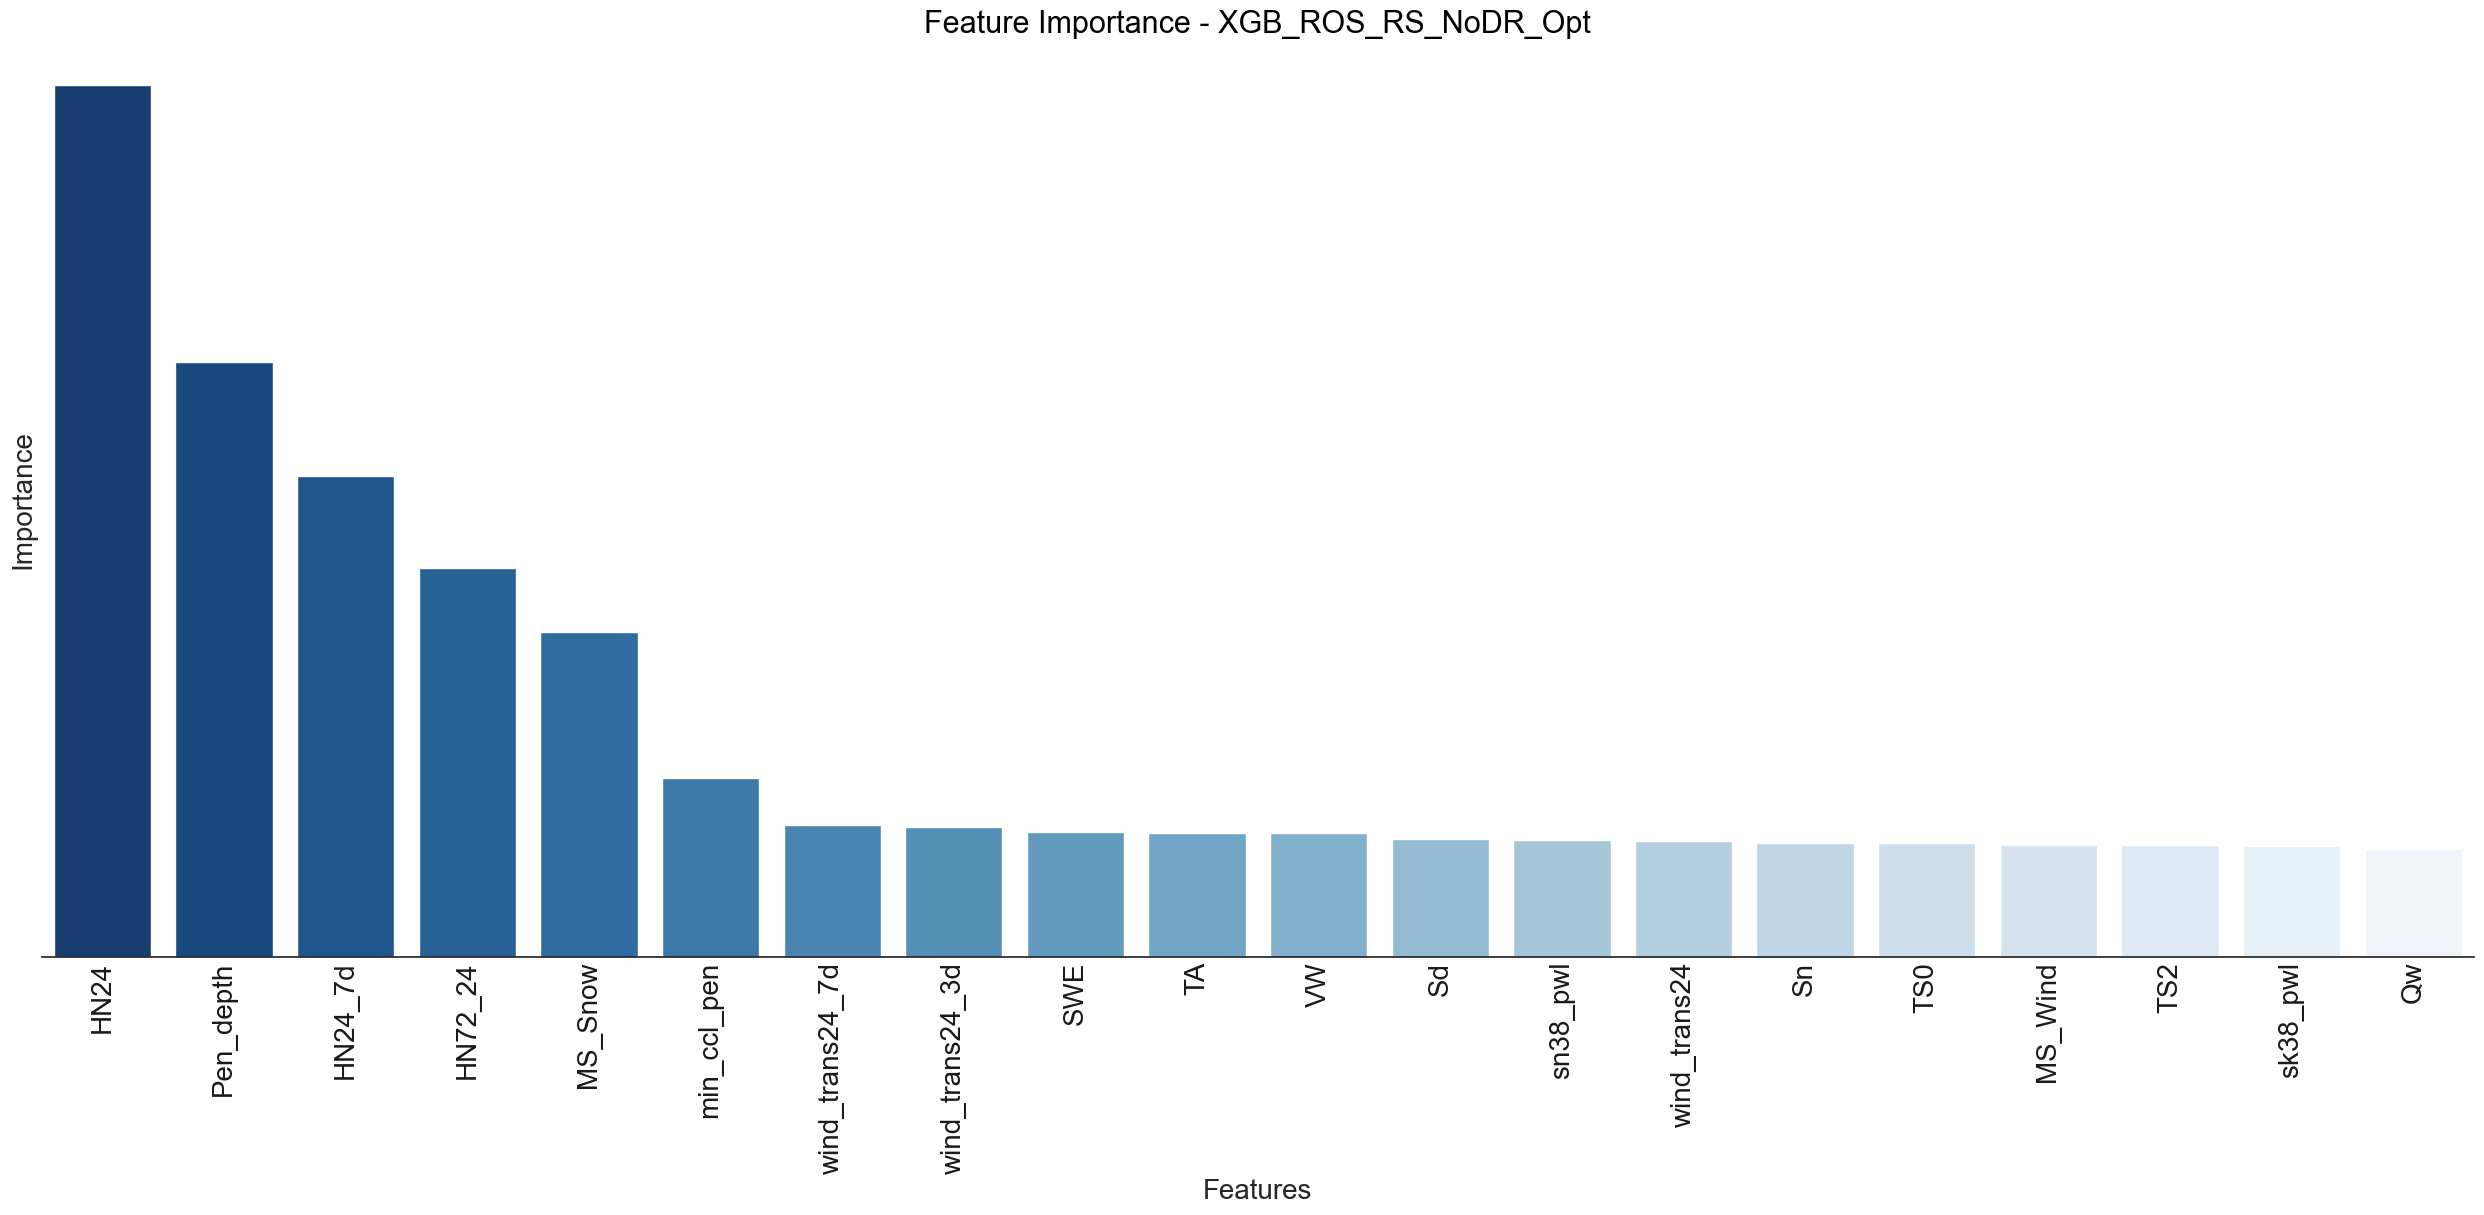

In [7]:
os.makedirs(os.path.join(IMG_DIR, MODEL_NAME), exist_ok=True)
importances = list(model.named_steps["classifier"].feature_importances_)
feature_importances = [(feature, round(importance, 4)) for feature, importance in zip(feature_names, importances)]
feature_importances = sorted(feature_importances, key = lambda x: x[1], reverse = True)
sorted_importances = [importance[1] for importance in feature_importances]
sorted_features = [importance[0] for importance in feature_importances]
RF1, RF1_imp = sorted_features,  sorted_importances 
palette = (sns.color_palette("Blues", len(RF1)))
palette.reverse()
title_font = {'size':'22', 'color':'black'}
sns.set(style = "white", palette = "muted", color_codes=True)
f, axes = plt.subplots(1, 1, figsize=(25, 12), sharex=False)
sns.despine(left=True)
sns.barplot(x=RF1, y=RF1_imp, hue=RF1, palette=palette, legend=False)
for ax in f.axes:
    ax.tick_params(labelrotation = 90)
    ax.tick_params(direction ='in', length = 6, width =0.5, colors = 'k', grid_color = 'k', grid_alpha = 0.5, labelsize = '20')
plt.setp(axes, yticks=[])
plt.xticks(fontsize=20)
plt.xlabel("Features", fontsize=20)
plt.ylabel("Importance", fontsize=20)
plt.tight_layout()
plt.title(f"Feature Importance - {MODEL_NAME}", fontdict=title_font)
plt.savefig(os.path.join(IMG_DIR, MODEL_NAME, f"feature_importance.png"), dpi=300, bbox_inches='tight')
plt.show()

### SHAP values

We compute the SHAP values for the test set:

In [8]:
os.makedirs(os.path.join(CSV_DIR, MODEL_NAME, 'winter_2020'), exist_ok=True)
shap_values, base_values = load_or_compute_shap(
    predictor=classifier.predict_proba, 
    processed_data=X_proc,
    feature_names=feature_names,
    class_names=class_names,
    dirpath=os.path.join(CSV_DIR, MODEL_NAME, 'winter_2020'), 
    prefix='shap_values_class_',
    overwrite=False
)

Found 5 CSV files. Loading them...


## 1. **Analysis**

### 1.1 **Global**

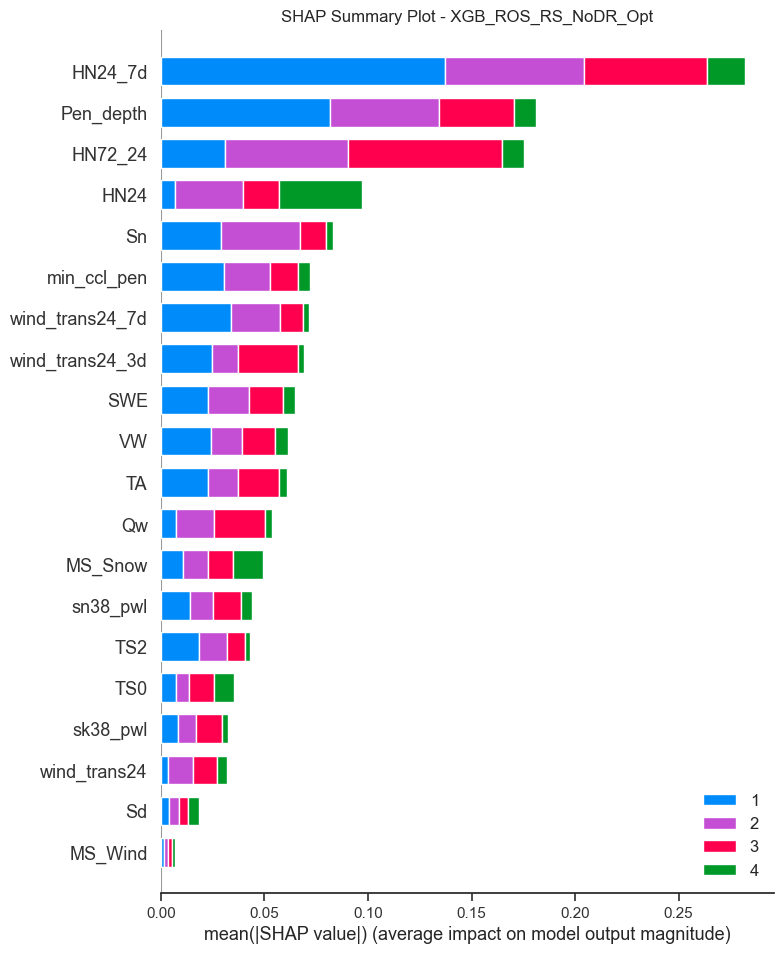

In [9]:
os.makedirs(os.path.join(IMG_DIR, MODEL_NAME, 'shap_summary'), exist_ok=True)
shap.summary_plot(shap_values, X_proc, plot_type='bar', class_names=class_names+1, feature_names=feature_names, max_display=30, show=False)
plt.title(f"SHAP Summary Plot - {MODEL_NAME}")
plt.savefig(os.path.join(IMG_DIR, MODEL_NAME, 'shap_summary', f"shap_summary.png"), dpi=300, bbox_inches='tight')
plt.show()

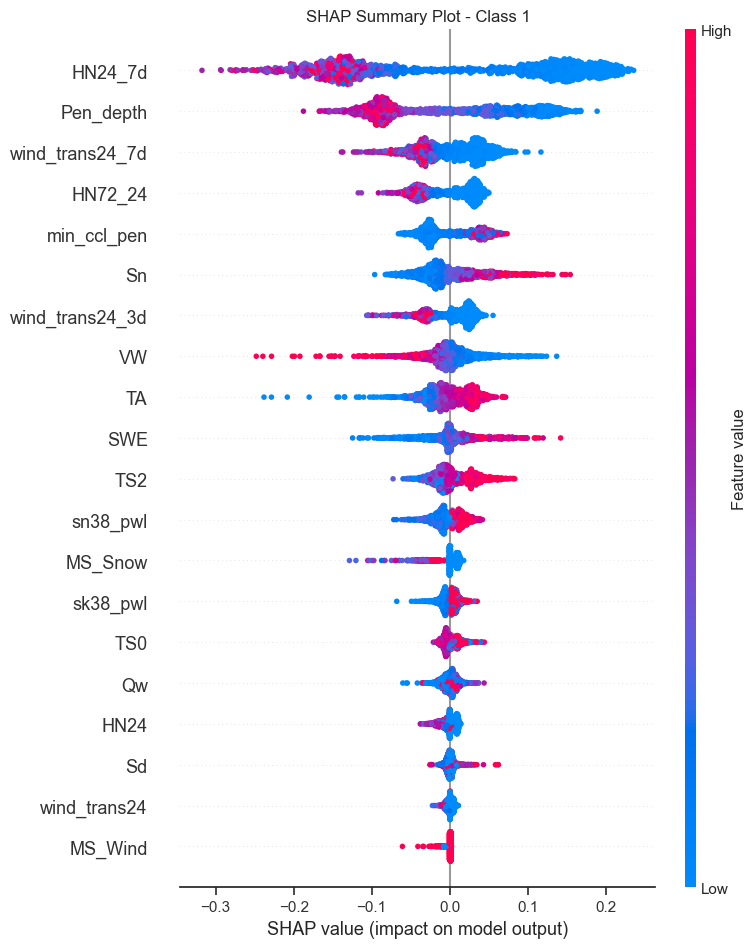

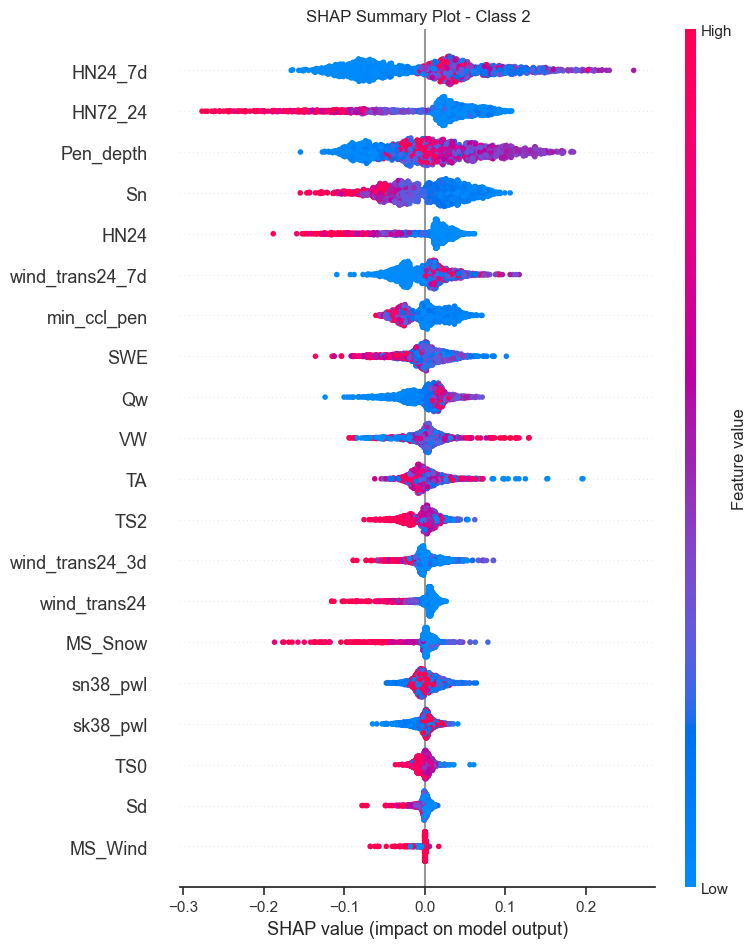

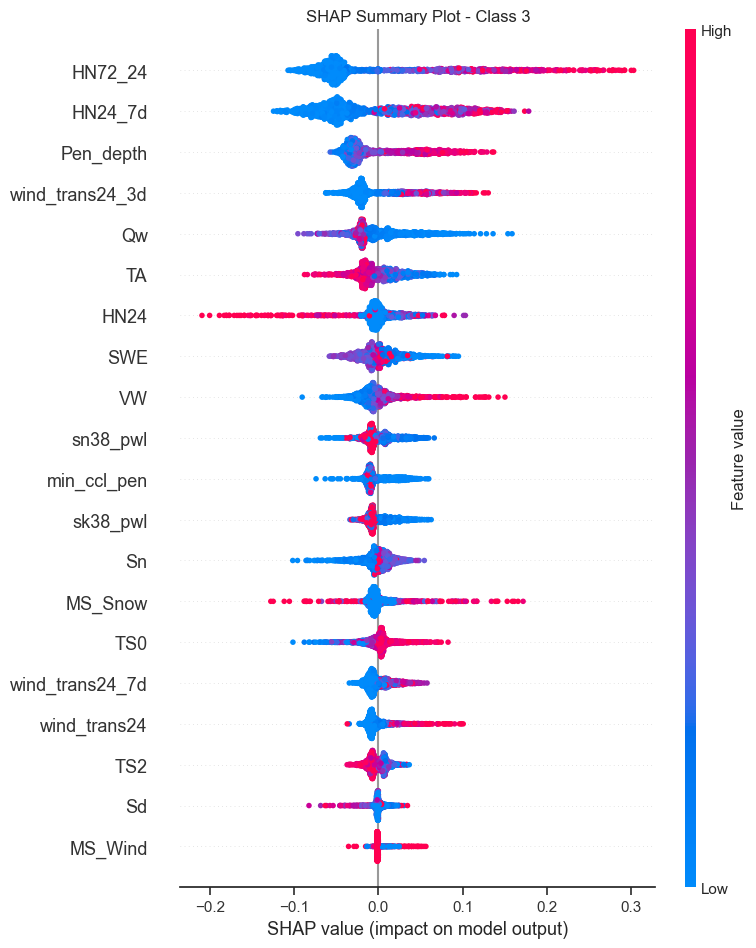

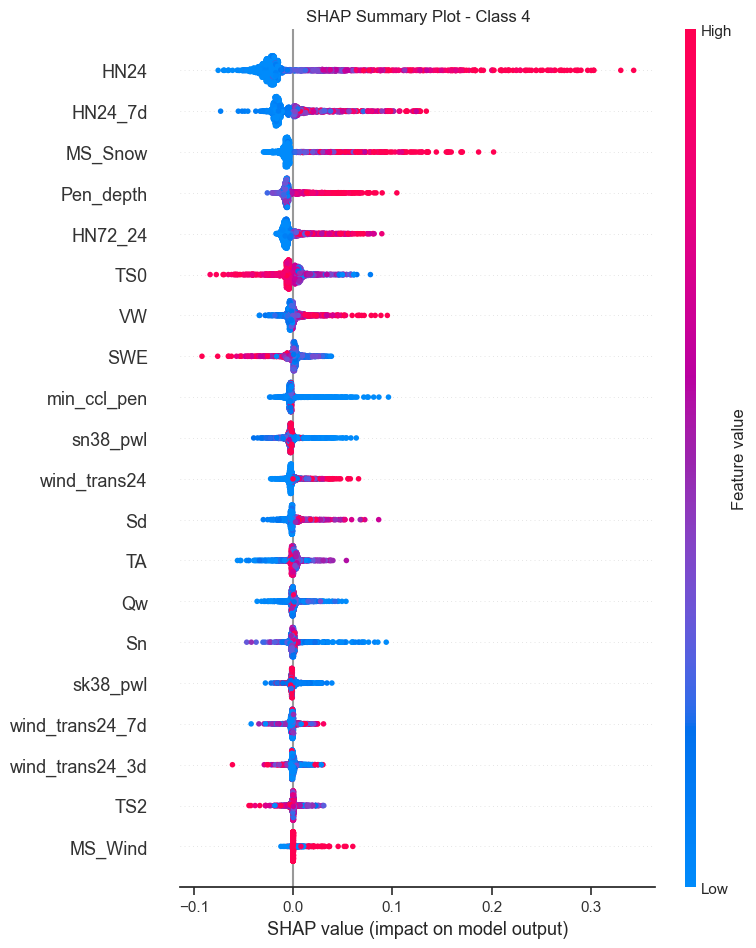

In [10]:
for i in range(shap_values.shape[2]):
    shap.summary_plot(
        shap_values[:, :, i], 
        X_proc, 
        feature_names=feature_names,
        plot_type='dot',
        show=False
    )
    plt.title(f"SHAP Summary Plot - Class {class_names[i] + 1}")
    plt.savefig(os.path.join(IMG_DIR, MODEL_NAME, 'shap_summary', f"shap_summary_class_{class_names[i]}.png"), dpi=300, bbox_inches='tight')
    plt.show()

### **Slice**

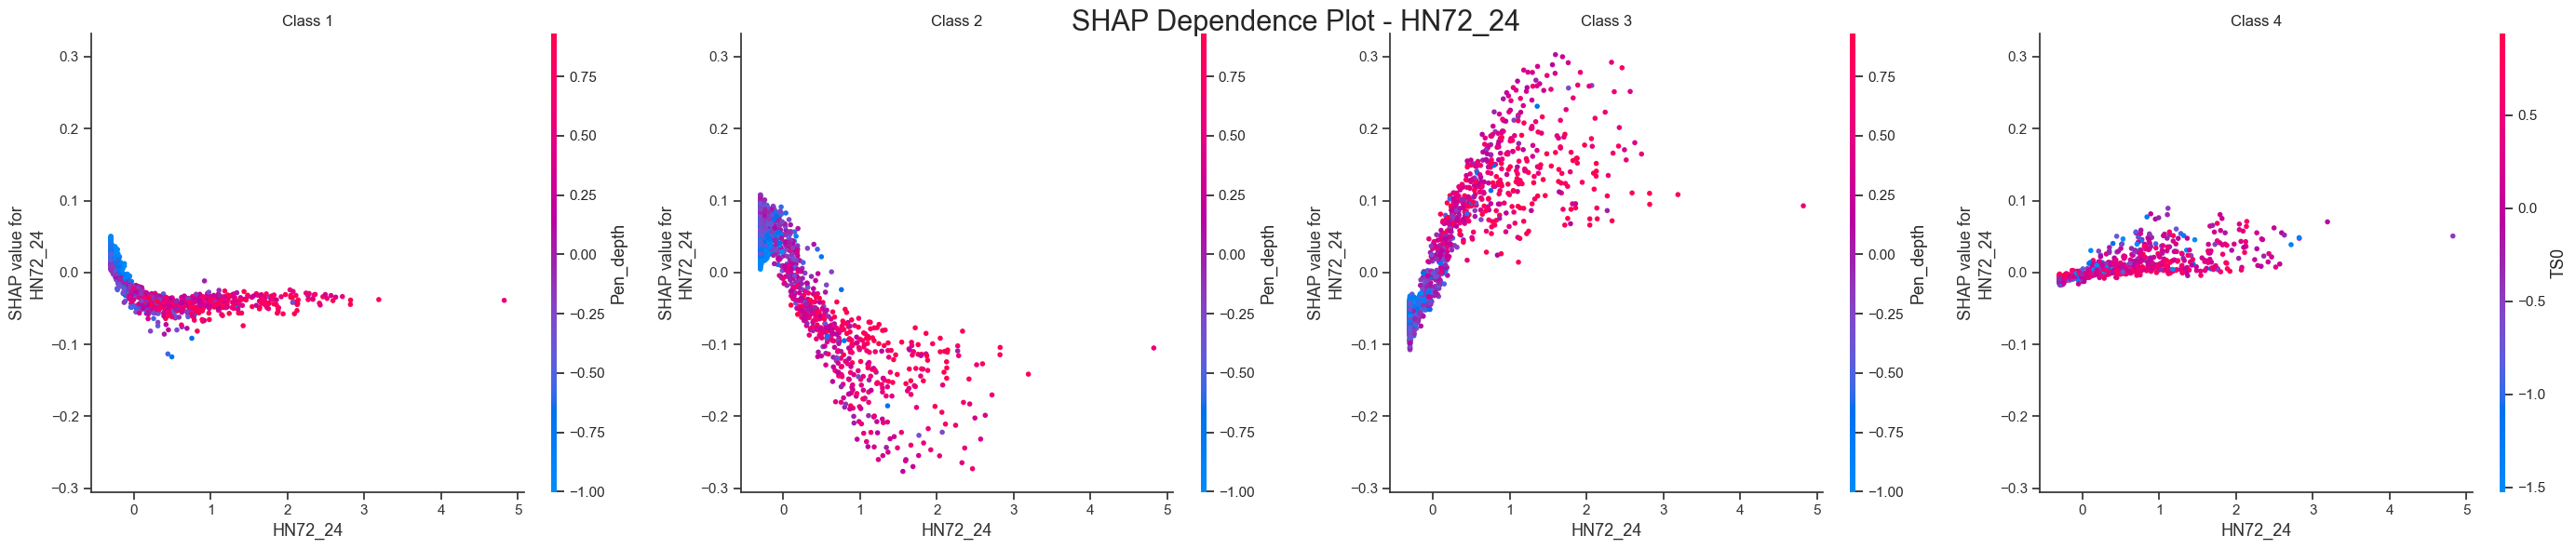

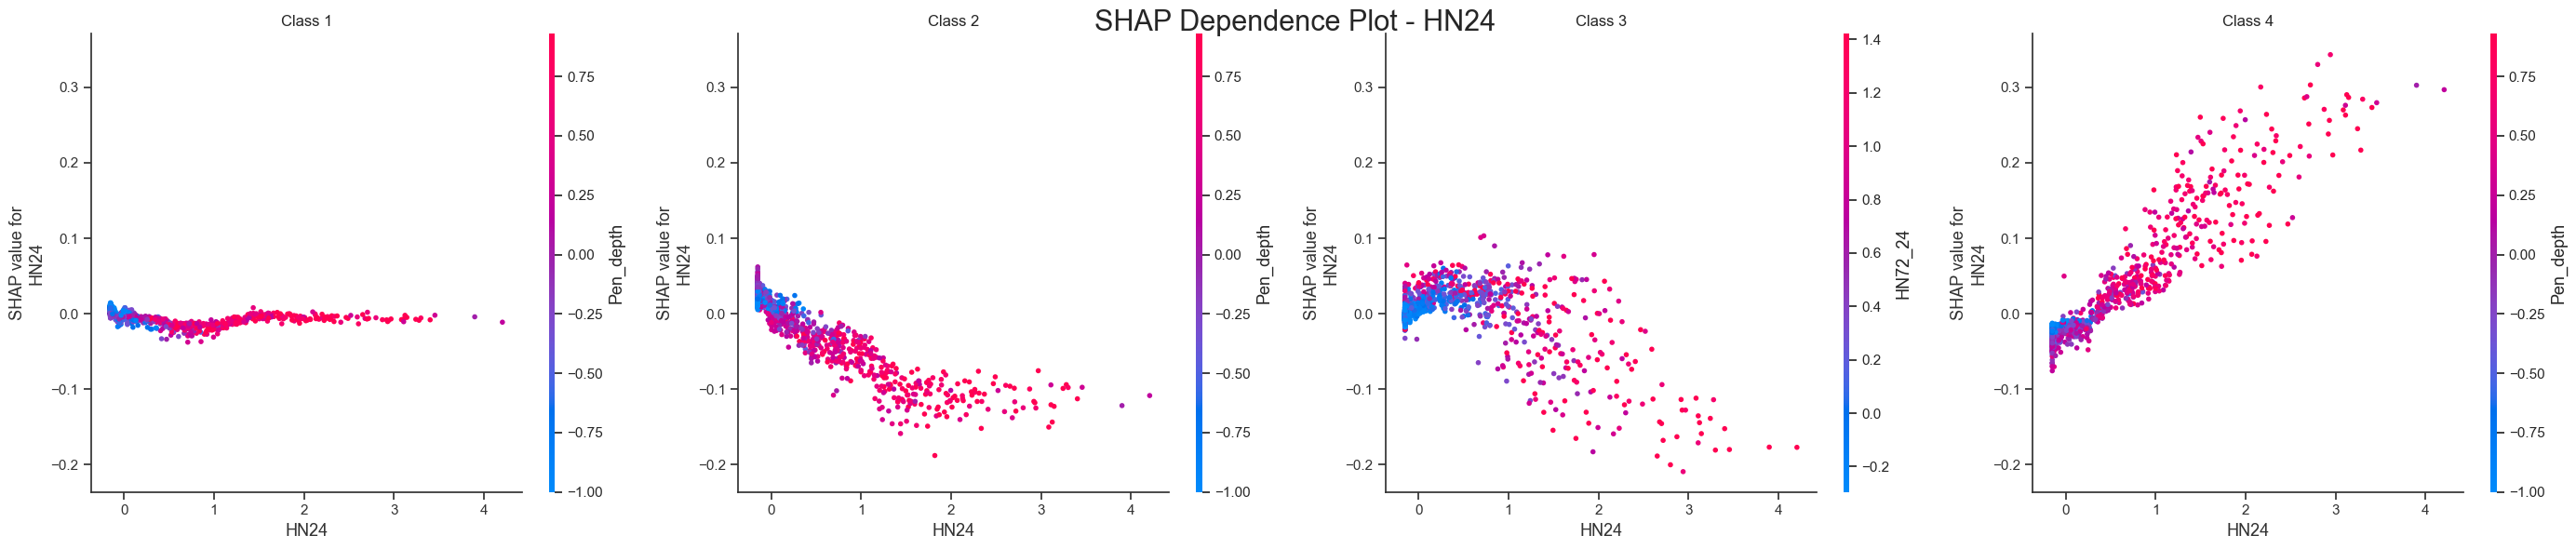

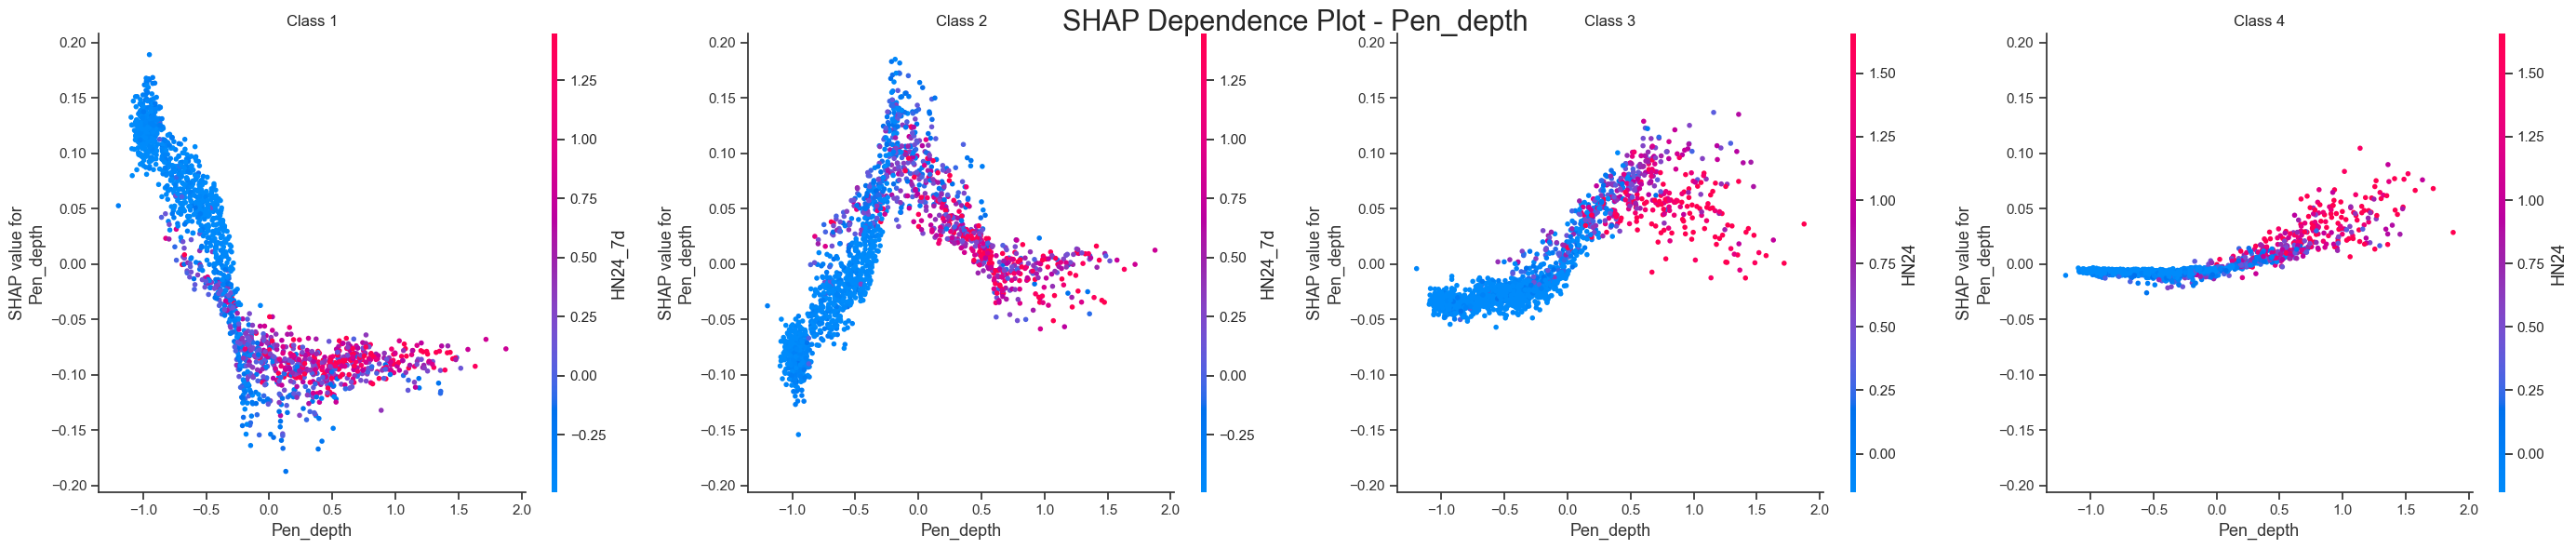

In [11]:
os.makedirs(os.path.join(IMG_DIR, MODEL_NAME, 'shap_dependence'), exist_ok=True)
for feat in ['HN72_24', 'HN24', 'Pen_depth']:
    fig, axes = plt.subplots(1, shap_values.shape[2], figsize=(28, 6), sharey=True)
    for i in range(shap_values.shape[2]):
        shap.dependence_plot(
            feature_names.index(feat),
            shap_values[:, :, i],
            X_proc,
            feature_names=feature_names,
            ax=axes[i],
            show=False
        )
        axes[i].set_title(f'Class {i+1}')
    plt.tight_layout()
    plt.suptitle(f"SHAP Dependence Plot - {feat}", fontsize=22)
    plt.savefig(os.path.join(IMG_DIR, MODEL_NAME, 'shap_dependence', f"shap_dependence_{feat}.png"), dpi=300, bbox_inches='tight')
    plt.show()

### **Local**

Choose most representative samples:

In [12]:
classes = [2]
results = {class_name: {} for class_name in classes}
for class_idx in range(shap_values.shape[2]):
    if class_names[class_idx] not in classes:
        continue
    sv = shap_values[:, :, class_idx]  # shape = (n_samples, n_features)
    sums = np.sum(np.abs(sv), axis=1)
    idx_med = np.argmin(np.abs(sums - np.median(sums)))
    idx_max = np.argmax(sums)
    idx_min = np.argmin(sums)
    idx_fp = np.where((model.predict(X_test) == class_names[class_idx]) & (y_test != class_names[class_idx]))[0][0]
    idx_fn = np.where((model.predict(X_test) != class_names[class_idx]) & (y_test == class_names[class_idx]))[0][0]
    results[class_names[class_idx]] = {
        'median': {
            'index': idx_med,
            'shap_value': sv[idx_med],
            'prediction': model.predict(X_test)[idx_med],
            'y_true': y_test.iloc[idx_med]
        },
        'max': {
            'index': idx_max,
            'shap_value': sv[idx_max],
            'prediction': model.predict(X_test)[idx_max],
            'y_true': y_test.iloc[idx_max]
        },
        'min': {
            'index': idx_min,
            'shap_value': sv[idx_min],
            'prediction': model.predict(X_test)[idx_min],
            'y_true': y_test.iloc[idx_min]
        },
        'false_positive': {
            'index': idx_fp,
            'shap_value': sv[idx_fp],
            'prediction': model.predict(X_test)[idx_fp],
            'y_true': y_test.iloc[idx_fp]
        },
        'false_negative': {
            'index': idx_fn,
            'shap_value': sv[idx_fn],
            'prediction': model.predict(X_test)[idx_fn],
            'y_true': y_test.iloc[idx_fn]
        }
    }

#### Force plot:

Class: 3


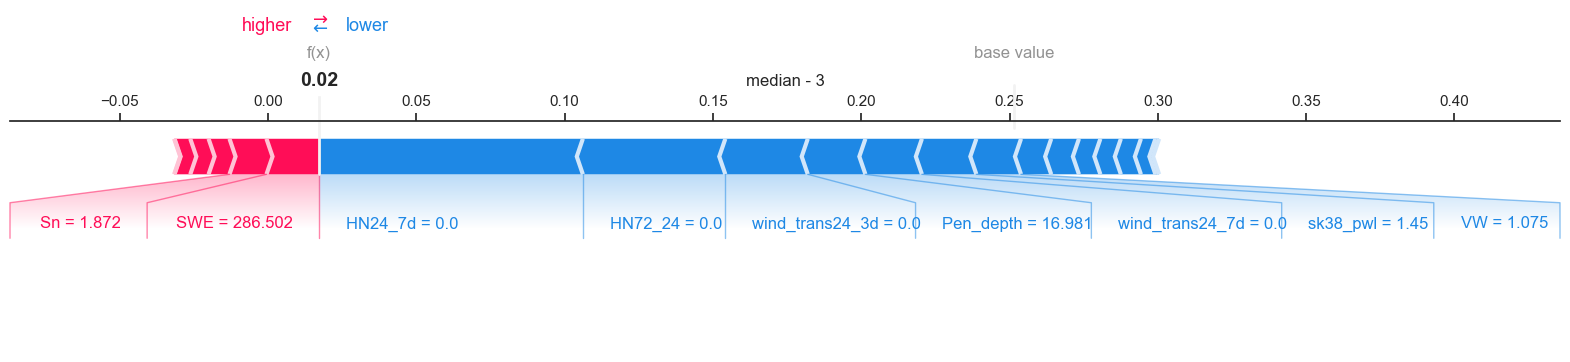

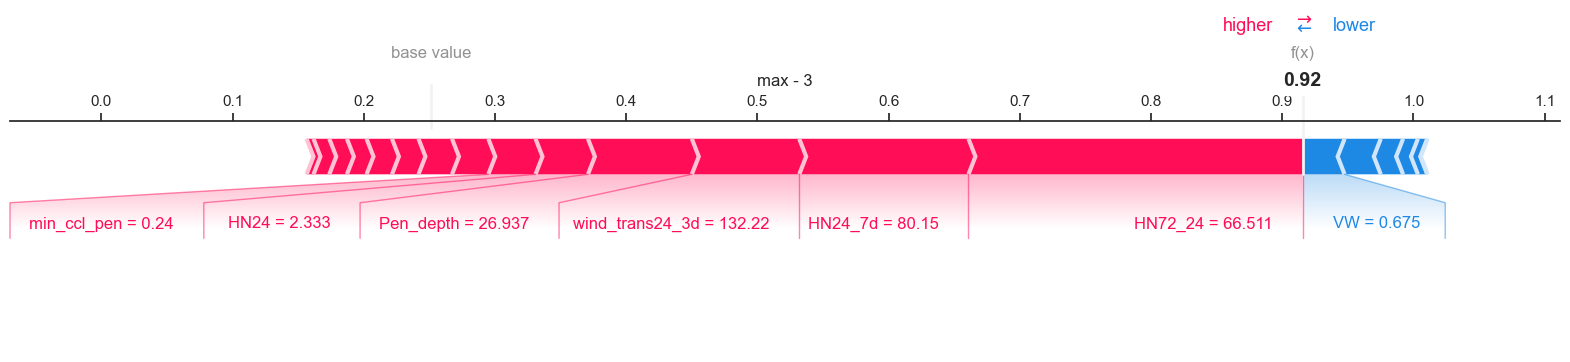

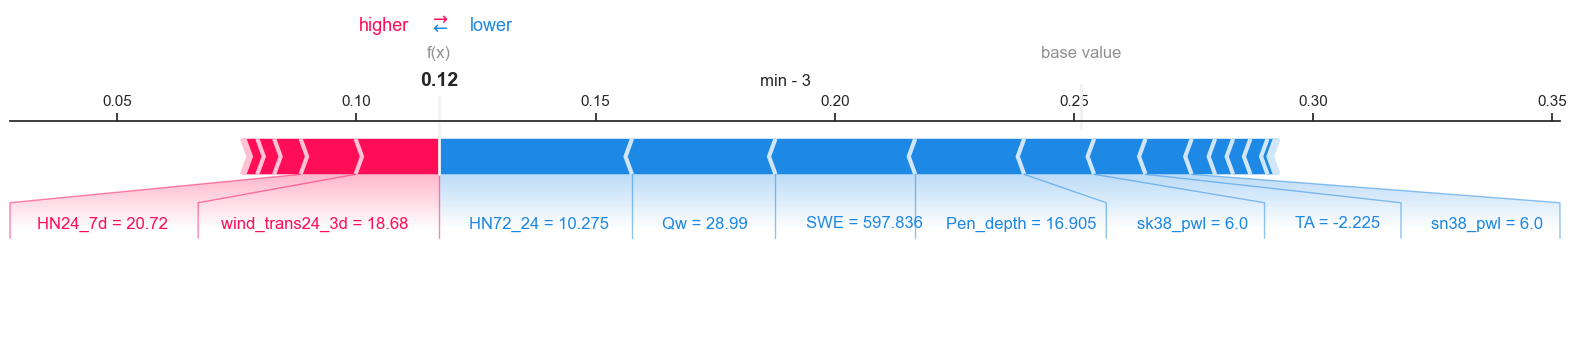

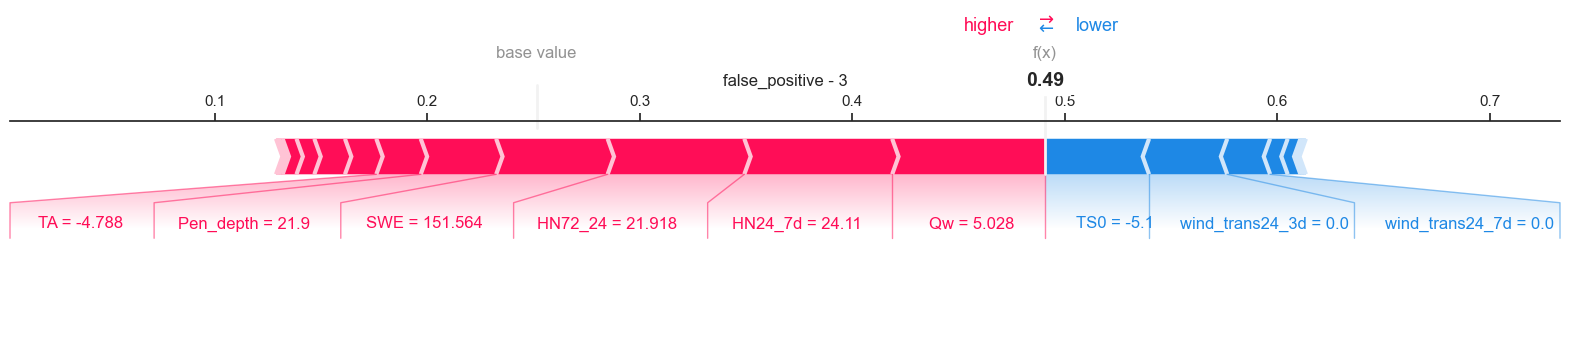

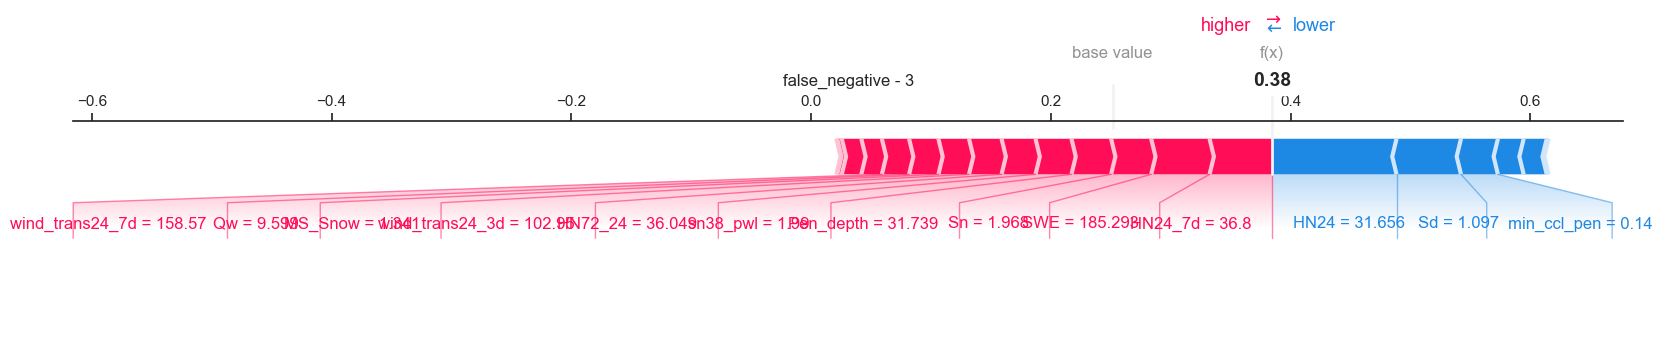

In [13]:
os.makedirs(os.path.join(IMG_DIR, MODEL_NAME, 'shap_force'), exist_ok=True)
for class_name, data in results.items():
    print(f"Class: {class_name+1}")
    for key, value in data.items():
        x_exp = shap.Explanation(
            base_values=base_values[value['index'], class_name],
            values=shap_values[value['index'], :, class_name],
            data=np.round(X_test.iloc[[value['index']]][feature_names].to_numpy()[0], 3), 
            feature_names=feature_names
        )
        fig_fp = shap.plots.force(x_exp, matplotlib=True, show=False)
        plt.title(f"{key} - {class_name+1}")
        plt.savefig(os.path.join(IMG_DIR, MODEL_NAME, 'shap_force', f"shap_force_plot_{class_name+1}_{key}.png"), dpi=300, bbox_inches='tight')
        plt.show(fig_fp)

#### Waterfall plot:

Class: 3


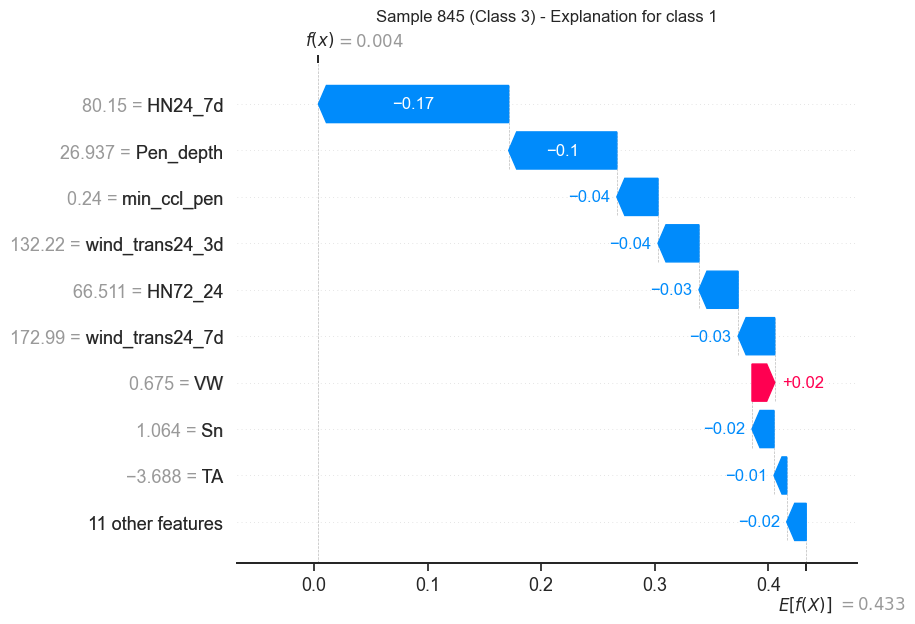

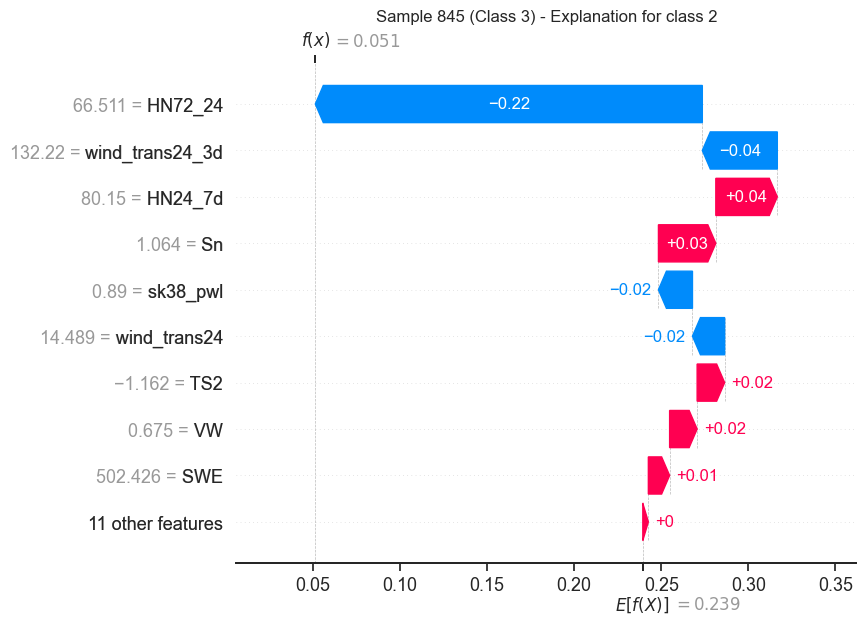

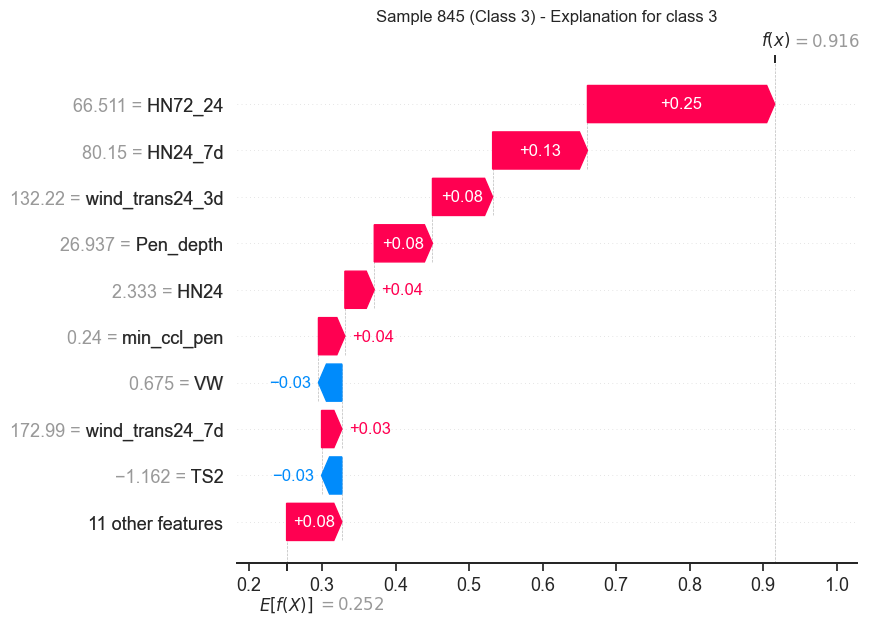

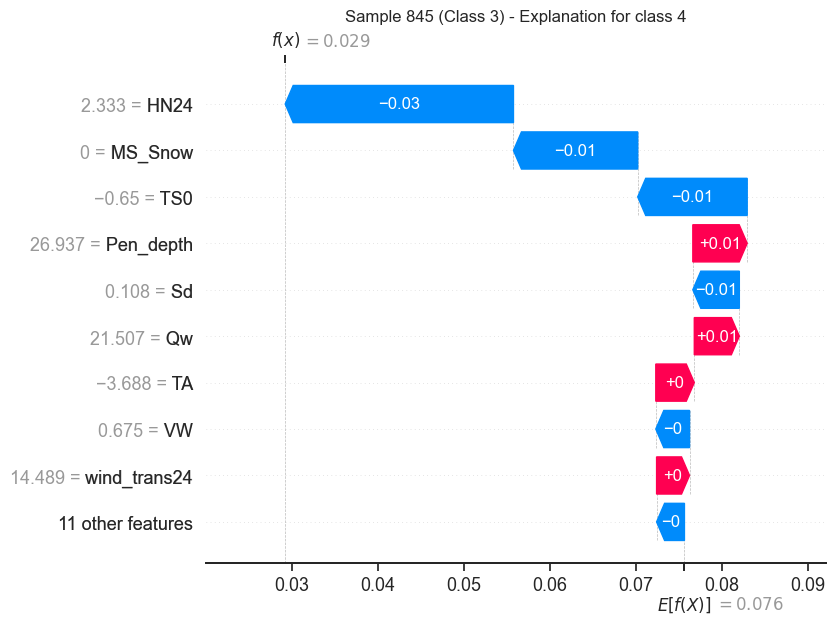

In [14]:
os.makedirs(os.path.join(IMG_DIR, MODEL_NAME, 'shap_waterfall'), exist_ok=True)
for class_name, data in results.items():
    print(f"Class: {class_name+1}")
    for key, value in data.items():
        if key not in ['max']:
            continue
        for cls in range(shap_values.shape[2]):
            x_exp = shap.Explanation(
                base_values=base_values[value['index'], cls],
                values=shap_values[value['index'], :, cls],
                data=np.round(X_test.iloc[[value['index']]][feature_names].to_numpy()[0], 3), 
                feature_names=feature_names
            )
            shap_plot = shap.waterfall_plot(x_exp,show=False)
            plt.title(f"Sample {value['index']} (Class {class_name+1}) - Explanation for class {cls+1}")
            #plt.savefig(os.path.join(IMG_DIR, MODEL_NAME, 'shap_waterfall', f"shap_waterfall_plot_{class_name+1}_{key}.png"), dpi=300, bbox_inches='tight')
            plt.show()